<a href="https://colab.research.google.com/github/Pravallika-02-datascience/Supervised-Machine-Learning-Algorithms/blob/main/K_Nearest_Neighbour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===============================================================
# K‑NEAREST NEIGHBOURS (KNN) – Animal Type Classification
# Dataset: Zoo.csv   ‑‑> 101 animals × 17 features + target label
# ===============================================================

# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 2. Load the data -------------------------------------------------------------
df = pd.read_csv('Zoo.csv')
print("Shape :", df.shape)
df.head()

Shape : (101, 18)


,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


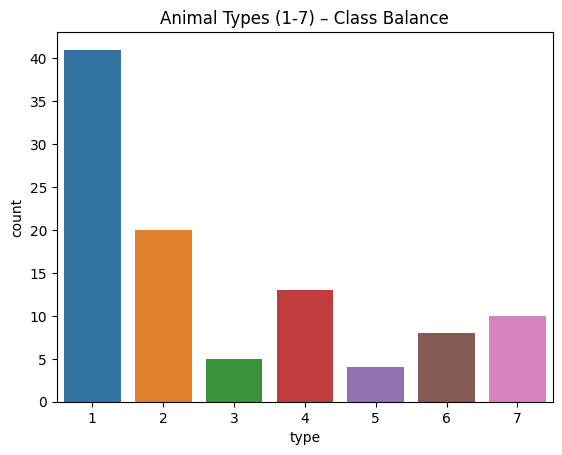

In [6]:
# 3. Quick EDA & Visualization -------------------------------------------------
# Target distribution
sns.countplot(x='type', data=df, palette='tab10')
plt.title('Animal Types (1‑7) – Class Balance')
plt.show()


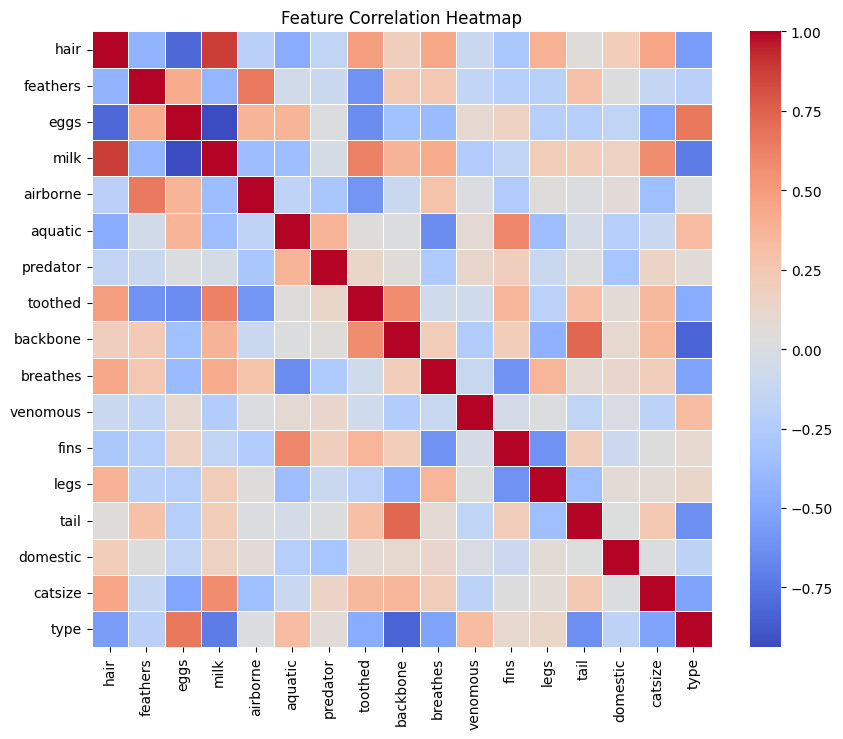

In [4]:
# Correlation heatmap (helps to see redundancy)
plt.figure(figsize=(10,8))
sns.heatmap(df.drop(columns=['animal name']).corr(),
            cmap='coolwarm', annot=False, linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

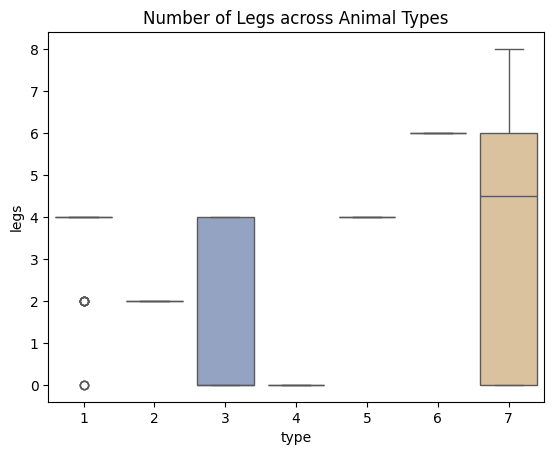

In [5]:
# Legs vs. Animal type (an easy numeric feature to visualise)
sns.boxplot(x='type', y='legs', data=df, palette='Set2')
plt.title('Number of Legs across Animal Types')
plt.show()

In [7]:
# 4. Pre‑processing ------------------------------------------------------------
# • No missing values (checked below) and mostly binary features.
print("Missing values per column:\n", df.isna().sum())

# Drop the identifier column ‑ it's not a useful feature
X = df.drop(columns=['animal name', 'type'])
y = df['type']

Missing values per column:
 animal name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
type           0
dtype: int64


In [8]:
# 5. Train‑test split (80/20 stratified so every type is represented) ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

In [9]:
# 6. Feature scaling (important for distance‑based models) ---------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [10]:
# 7. Hyper‑parameter tuning for K and distance metric --------------------------
param_grid = {
    'n_neighbors': list(range(1, 16, 2)),         # odd K from 1→15
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

grid = GridSearchCV(KNeighborsClassifier(),
                    param_grid,
                    cv=5,            # 5‑fold cross‑validation
                    scoring='accuracy')
grid.fit(X_train_scaled, y_train)

print("Best params :", grid.best_params_)
print("Best CV accuracy : {:.3f}".format(grid.best_score_))

Best params : {'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'}
Best CV accuracy : 0.963


In [12]:
# 8. Evaluate the best model on the hold‑out test set --------------------------
best_knn = grid.best_estimator_
y_pred   = best_knn.predict(X_test_scaled)

print("\nTest accuracy  : {:.3f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification report:\n",
      classification_report(y_test, y_pred, digits=3))





Test accuracy  : 1.000

Classification report:
               precision    recall  f1-score   support

           1      1.000     1.000     1.000         8
           2      1.000     1.000     1.000         4
           3      1.000     1.000     1.000         1
           4      1.000     1.000     1.000         3
           5      1.000     1.000     1.000         1
           6      1.000     1.000     1.000         2
           7      1.000     1.000     1.000         2

    accuracy                          1.000        21
   macro avg      1.000     1.000     1.000        21
weighted avg      1.000     1.000     1.000        21



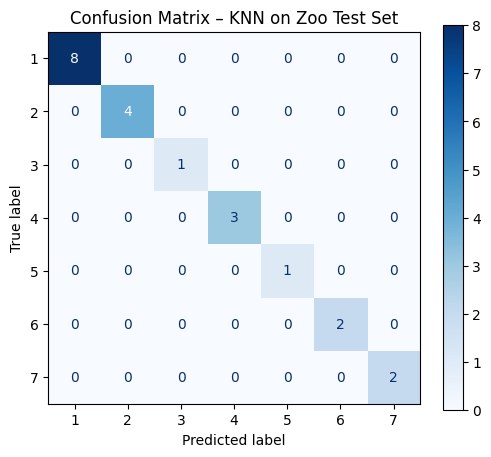

In [13]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(6,5))
ConfusionMatrixDisplay.from_estimator(best_knn, X_test_scaled, y_test,
                                      display_labels=sorted(y.unique()),
                                      cmap='Blues', ax=ax, xticks_rotation=0)
plt.title('Confusion Matrix – KNN on Zoo Test Set')
plt.show()


In [14]:
# 9. Visualise decision boundaries (PCA → 2‑D) ---------------------------------
#   – Reduce the 16‑D feature space to 2 principal components
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

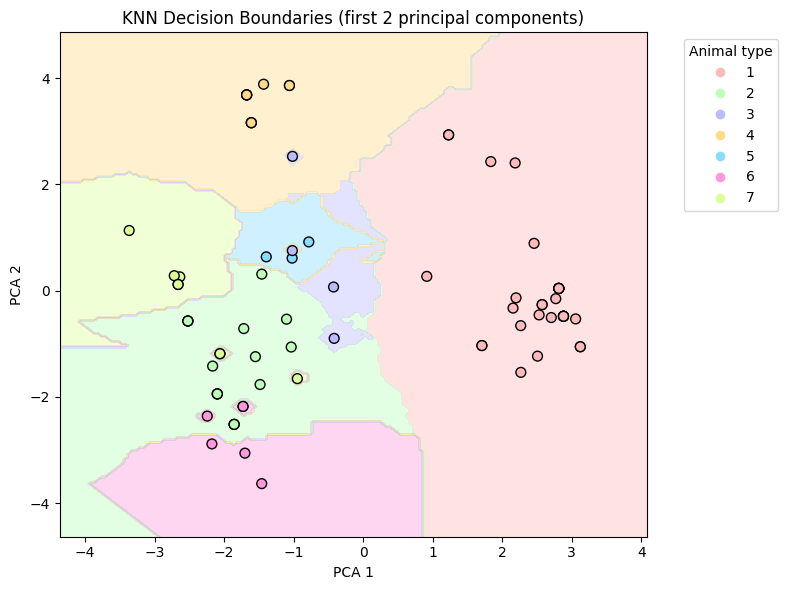

In [15]:
#   – Re‑train KNN on the 2‑D space so we can plot contours
knn_2d = KNeighborsClassifier(**grid.best_params_)
knn_2d.fit(X_train_pca, y_train)

#   – Create a meshgrid over the 2‑D space
h = 0.05  # step size
x_min, x_max = X_train_pca[:,0].min() - 1, X_train_pca[:,0].max() + 1
y_min, y_max = X_train_pca[:,1].min() - 1, X_train_pca[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

#   – Colour map for up to 7 classes
colors = ListedColormap(['#FFBBBB','#BBFFBB','#BBBBFF',
                         '#FFDD88','#88DDFF','#FF99DD','#DDFF99'])

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap=colors, alpha=0.4)

#   – Plot training points
scatter = plt.scatter(X_train_pca[:,0], X_train_pca[:,1],
                      c=y_train, cmap=colors, edgecolor='k', s=50)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('KNN Decision Boundaries (first 2 principal components)')
plt.legend(*scatter.legend_elements(prop='colors'),
           title="Animal type", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()